In [1]:
import sys; sys.path.append("../src2")
from pendulum import *
import numpy as np, matplotlib.pyplot as plt, pickle
%matplotlib inline

# Behaviour Tree

In [2]:
class controller(Tree):
    
    def __init__(self, xmin, xmax, tmax, mbc, nnc):
        
        # parameters
        self.xmin = xmin
        self.xmax = xmax
        self.tmax = tmax
        
        # controllers
        self.mbc = mbc
        self.nnc = nnc
        
        # behaviour tree
        fb0 = Fallback([self.safety_okay, self.emergency_controller])
        #se0 = Sequence([self.execution_time_okay, self.not_terminal])
        #fb1 = Fallback([se0, self.model_based_controller])
        fb1 = Fallback([self.execution_time_okay, self.model_based_controller])
        se1 = Sequence([fb0, fb1, self.neural_network_controller])
        Tree.__init__(self, se1)
        
        # initial configuration
        self.controller = self.nnc
        
    def not_terminal(self):
        x, v, theta, omega = self.state
        if abs(theta)%2*np.pi < 0.1 and abs(x) < 0.1:
            return 0
        else:
            return 1
        
    def safety_okay(self):
        x, v, theta, omega = self.state
        if x < self.xmin or x > self.xmax:
            return 0
        else:
            return 1
        
    def execution_time_okay(self):
        if self.time >= self.tmax:
            return 0
        else:
            return 1
        
    def emergency_controller(self):
        self.controller = self.mbc
        return 2
    
    def model_based_controller(self):
        self.controller = self.mbc
        return 2
    
    def neural_network_controller(self):
        self.controller = self.nnc
        return 2
    
    def __call__(self, time, state): # intermediate integration steps
        return self.controller(time, state)
    
    def control(self, time, state): # succesfull integration steps
        self.time = time
        self.state = state
        Tree.__call__(self)
        return self.controller.control(time, state)

# Case 0: MBC catches NNC

In [91]:
# model based controller
#mbc = srinivasan(0.0, 0, 1, 0.1, 4)
mbc = srinivasan(0.1, 0.1, 15, 10, 1, 0)

# set initial reference angle
mbc.tr = 0

# neural network controller
nn = pickle.load(open("nn.p", "rb"))
nnc = mlp_controller(nn)

# behaviour tree controller
cont = controller(-3, 13, 10, mbc, nnc)

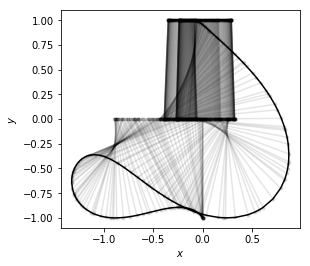

In [98]:
# simulate
x0 = [0,0,np.pi,0]
dyn  = dynamics(x0,[0,0,0,0], 0)
t, x, u = dyn.propagate_controlled(40, cont)
fig, ax = plt.subplots(1)
plot_traj(x, arm=True, n=500, ax=ax)
fig.savefig("timeout.pdf", bbox_inces="tight")
#plot_controls(t, u)

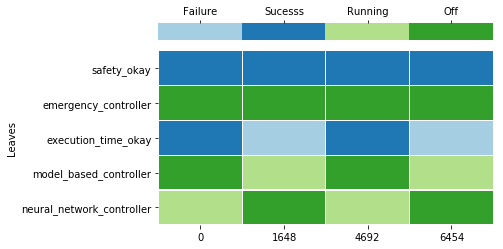

In [95]:
# light blue = False, dark blue = True, light green = running
# dark green = off
cont.plot(duplicates=False)

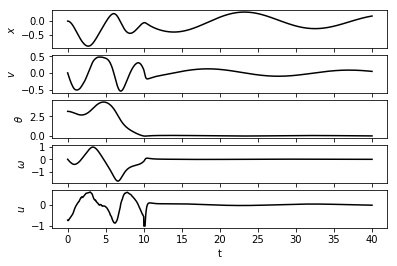

In [96]:
ax = plot_states(t, x, u)

In [7]:
np.linspace(0,1,9)[1::2]

array([0.125, 0.375, 0.625, 0.875])

In [ ]:
%matplotlib